# Statistik und fitting!

In [33]:
# Mittelwert
# Median
# Varianz ausrechnen
# from scratch implementierung von mittelwert
# funktionsdefinitionen & argsort

Wir bauen uns ein Konzentrations über pH diagramm!

In [34]:
from pHcalc import Acid, Inert, System
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# wir nehmen als allererstes HCl welches komplett in wasser dissoziieren sollte!
# aus der dokumentation:  H3O+ and Cl-. Because H3O+ is adjusted internally, all you need to define is Cl-. 
# This implies a single equivalent of H3O+ in order to balance the charge of the system.
cl = Inert(charge=-1, conc=0.01)
system = System(cl)
system.pHsolve()
print(system.pH) # Should print 1.9999

1.9999977111816385


Warum ist das so? Was sagt der pH wert aus?

Aufgabe 1: Berechnen Sie alle pH Werte für alle Konzentrationen von HCl von $10^{-9}$ bis $1$ Mol/L und plotten Sie das Ergebnis. Die schritte sollten pro Dekade immer 10 Messpunkte haben!

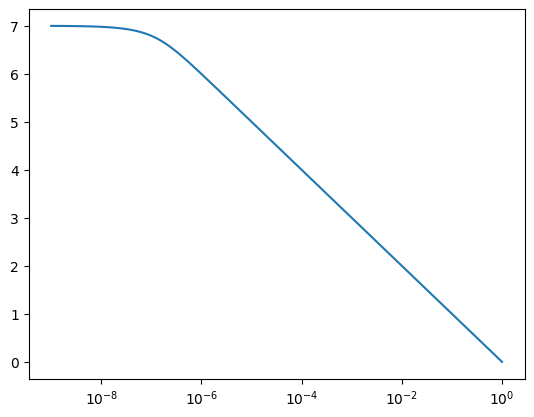

In [36]:
#ihr code hier
concli = np.geomspace(10**-9, 1, 100)

phs = []
for conc in concli:
    cl = Inert(charge=-1, conc=conc)
    system = System(cl)
    system.pHsolve()
    phs.append(system.pH)

plt.semilogx(concli, phs)

Nun das ganze mit NaOH

In [37]:
na = Inert(charge=1, conc=0.01)
system = System(na)
system.pHsolve()
print(system.pH) # Should print 12.00000

12.000002288818362


Titrieren sie nun $10^{-9}$ bis $1$ Mol/L NaOH und plotten sie den pH wert!

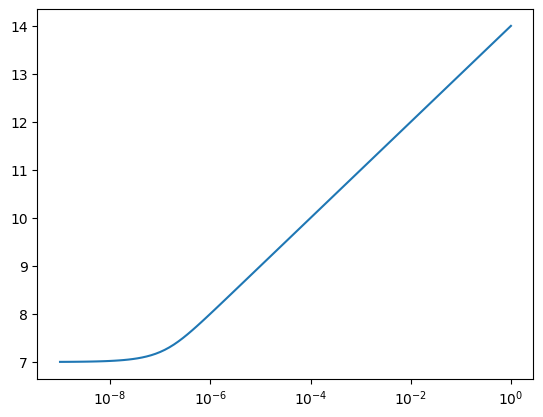

In [38]:
concli2 = np.geomspace(10**-9, 1, 100)

phs1 = []
for conc in concli2:
    na = Inert(charge=1, conc=conc)
    system = System(na)
    system.pHsolve()
    phs1.append(system.pH)

plt.semilogx(concli2, phs1)

Wie immer können wir auch gefährliche Dinge sehr easy im computer lösen!
Titrieren sie nun HF von $10^{-9}$ bis 1 Mol/L in 1000 Schritten.

In [39]:
#Beispielcode
hf = Acid(Ka=6.76e-4, charge=0, conc=0.01)
# hf = Acid(pKa=3.17, charge=0, conc=0.01) will also work
system = System(hf)
system.pHsolve()
print(system.pH) # Should print 2.6413261

2.6413261413574203


# Kompliziertes beispiel $(NH_4)_3PO_4$

In [40]:
# Bitte ebenfalls von 10**-9 bis 1 plotten
phos = Acid(pKa=[2.148, 7.198, 12.319], charge=0, conc=0.01)
nh4 = Acid(pKa=9.25, charge=1, conc=0.01*3)
system = System(phos, nh4)
system.pHsolve()
print(system.pH) # Should print 8.95915298

8.95915298461914


# Finally Some Data Science!

Was wenn wir die pKa werte nicht wissen?

Wir nehmen mal an, dass die folgende Simulation eine Messung sei!

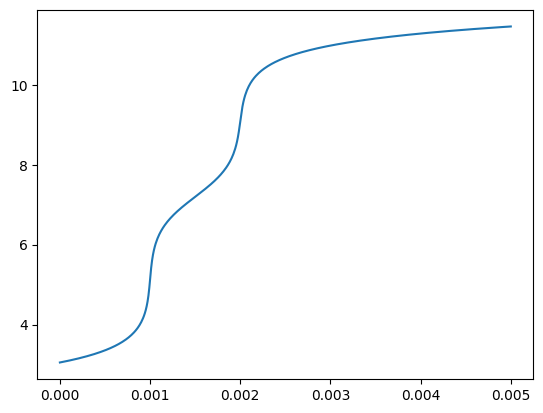

In [41]:
#  H3PO4 with NaOH aber linear!
na_moles = np.linspace(1e-8, 5.e-3, 500)
sol_volume = 1. # Liter
phos = Acid(pKa=[2.148, 7.198, 12.375], charge=0, conc=1.e-3)
phs = []
for mol in na_moles:
     na = Inert(charge=1, conc=mol/sol_volume)
     system = System(phos, na)
     system.pHsolve(guess_est=True)
     phs.append(system.pH)
plt.plot(na_moles, phs)
plt.show()

Messungen haben idR etwas Unsicherheit und daher Rauschen ... fügen wir das hinzu! 

In [42]:
phs_noise = np.array(phs) + np.random.normal(0,0.1,len(phs))

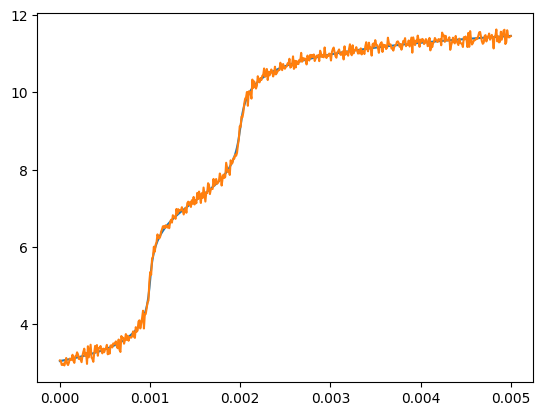

In [43]:
plt.plot(na_moles, phs)
plt.plot(na_moles, phs_noise)
plt.show()

Plotten Sie als histogramm nun nur den Fehler aus der "perfekten" simlation und unserer "fake messung" welche verrauscht ist.

Berechnen Sie den MSE, MAE, R2, Fehlervarianz und den Absoluten Fehler

0.010190785074851877 0.08056727761380034
0.9921368521043249


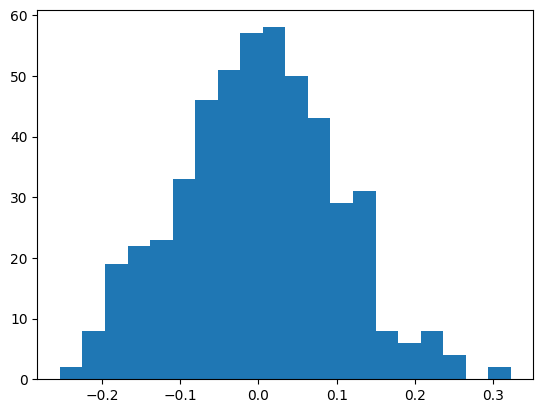

In [ ]:
diff = np.array(phs)-np.array(phs_noise)
_ = plt.hist(diff, 20)

mse = np.mean(diff**2)
mae = np.mean(np.abs(diff))
print(mse, mae)

r2 = 1-np.mean(diff**2/(phs-np.mean(phs))**2)
print(r2)

''' 0-0.5 keine Vorhersagekraft
    0.5-0.8 schwach
    0.8 gut
    0.9 sehr gut
    1.0 perfekt (zu gute Vorhersage)
''' 

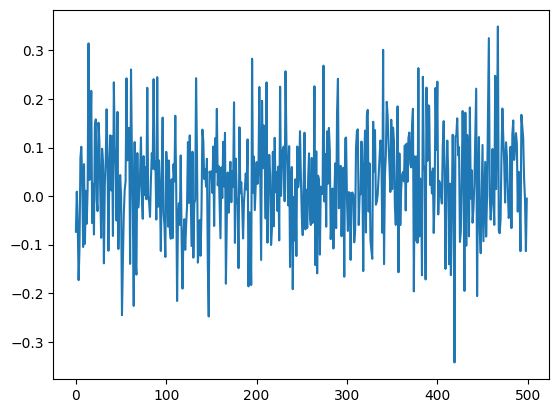

In [45]:
fehler = np.random.normal(0,0.1,len(phs))+na_moles*10
plt.plot(fehler)

Wie könnten wir die pKa/pkS werte herausfinden wenn wir nun wirklich eine Messung vorliegen hätten?
Ausprobieren?
Fitten!

Schreiben Sie zunächst eine funktion welche den pH berechner wenn eine liste von länge 3 übergeben wird

Hier ist ein Beispielcode zum fitten mittels scipy optimize minimize:

In [46]:
import numpy as np
from scipy.optimize import minimize

# Definiere die Zielfunktion, die Sie minimieren möchten
def objective_function(params):
    x, y, z = params
    # Beispiel: Quadratische Funktion (ersetze sie durch deine Funktion)
    return (x - 2)**2 + (y - 3)**2 + (z - 1)**2

# Setze die Startwerte für die Parameter
initial_guess = [0.0, 0.0, 0.0]

# Optional: Definiere Nebenbedingungen (Gleichungen oder Ungleichungen)
constraints = [
    # Beispiel für eine Gleichung: x + y + z = 1
    {'type': 'eq', 'fun': lambda params: params[0] + params[1] + params[2] - 1}
]

bounds = [
    (None, None),  # Keine Grenze für x
    (0, None),     # y ≥ 0
    (None, 5)      # z ≤ 5
]

# Führe die Optimierung durch
result = minimize(
    objective_function,
    initial_guess,
    method='SLSQP',  # Ändere den Algorithmus, falls erforderlich
    bounds=bounds,
    constraints=constraints
)

if result.success:
    print("Optimierung erfolgreich!")
    print("Optimale Parameter:", result.x)
else:
    print("Optimierung fehlgeschlagen:", result.message)

print("Minimaler Wert der Zielfunktion:", result.fun)


Optimierung erfolgreich!
Optimale Parameter: [ 0.33333333  1.33333332 -0.66666665]
Minimaler Wert der Zielfunktion: 8.333333333333334


Hier schreiben Sie nun code um die pKa werte zu finden